# Collaborative Delivery Route Optimisation — Balanced Multi-Depot

This notebook models a collaborative delivery routing problem with multiple depots and vehicles.

We will:
1. Define the depot and customer locations.
2. Set up the distance matrix and vehicle constraints.
3. Build the OR-Tools routing model.
4. Solve for balanced routes minimizing total distance.
5. Print and visualise the resulting routes.



In [1]:
# imports
from math import sqrt

try:
    from ortools.constraint_solver import pywrapcp, routing_enums_pb2
except Exception as e:
    raise SystemExit(
        "OR-Tools not found. Install with:\n    pip install ortools numpy\nThen run this notebook again."
    )

In [2]:
# ---------------- Scenario (balanced across depots) ----------------
locations = {
    "Depot A": (10, 50),
    "Depot B": (60, 50),
    # Near Depot A
    "C1": (12, 45), "C2": (15, 55), "C3": (20, 48),
    "C4": (18, 60), "C5": (22, 52), "C6": (25, 45),
    # Near Depot B
    "C7": (58, 47), "C8": (62, 53), "C9": (65, 48),
    "C10": (68, 55), "C11": (55, 60), "C12": (70, 45),
}

# Vehicles per depot
vehicles_per_depot = {"Depot A": 2, "Depot B": 2}

# Node helpers
node_names = list(locations.keys())
index_of = {name: i for i, name in enumerate(node_names)}
coords = [locations[n] for n in node_names]

# Euclidean distance function
def euclid(a, b):
    return int(round(((a[0] - b[0])**2 + (a[1] - b[1])**2) ** 0.5))

# Distance matrix
n = len(coords)
distance_matrix = [[euclid(coords[i], coords[j]) for j in range(n)] for i in range(n)]

# Starts/ends per vehicle
starts, ends = [], []
for depot_name, cnt in vehicles_per_depot.items():
    depot_idx = index_of[depot_name]
    for _ in range(cnt):
        starts.append(depot_idx)
        ends.append(depot_idx)

num_vehicles = len(starts)

In [3]:
# ---------------- OR-Tools Routing Model ----------------
manager = pywrapcp.RoutingIndexManager(n, num_vehicles, starts, ends)
routing = pywrapcp.RoutingModel(manager)

# Distance cost callback
def dist_cb(from_index, to_index):
    i = manager.IndexToNode(from_index)
    j = manager.IndexToNode(to_index)
    return distance_matrix[i][j]

transit_idx = routing.RegisterTransitCallback(dist_cb)
routing.SetArcCostEvaluatorOfAllVehicles(transit_idx)

In [4]:
# Demand per customer (0 for depots)
def demand_cb(index):
    node = manager.IndexToNode(index)
    return 0 if node_names[node].startswith("Depot") else 1

demand_idx = routing.RegisterUnaryTransitCallback(demand_cb)
vehicle_capacities = [4] * num_vehicles  # each truck can handle up to 4 customers
routing.AddDimensionWithVehicleCapacity(
    demand_idx, 0, vehicle_capacities, True, "Capacity"
)

True

In [5]:
# Keeps routes local & balanced
routing.AddDimension(
    transit_idx,  # distance callback
    0,            # slack
    120,          # max distance per vehicle
    True,
    "Distance"
)

True

In [6]:
# Arc Count Dimension (at least 1 customer per vehicle)
def one_per_arc_cb(from_index, to_index):
    return 1

arc_idx = routing.RegisterTransitCallback(one_per_arc_cb)
routing.AddDimension(arc_idx, 0, 1000, True, "ArcCount")
arc_dim = routing.GetDimensionOrDie("ArcCount")
solver = routing.solver()
for v in range(num_vehicles):
    end_cumul = arc_dim.CumulVar(routing.End(v))
    solver.Add(end_cumul >= 2)  # ensures at least one customer on each route

In [7]:
# Search Parameters & Solve
search = pywrapcp.DefaultRoutingSearchParameters()
search.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
search.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
search.time_limit.FromSeconds(15)
search.log_search = False

solution = routing.SolveWithParameters(search)

In [8]:
# Print Solution
def print_solution():
    total_distance = 0
    for v in range(num_vehicles):
        index = routing.Start(v)
        route_nodes = []
        route_distance = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_nodes.append(node_names[node_index])
            prev = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(prev, index, v)
        route_nodes.append(node_names[manager.IndexToNode(index)])
        total_distance += route_distance
        print(f"Truck {v}: distance = {route_distance:3d}  route = {route_nodes}")
    print(f"\nTotal distance for all vehicles: {total_distance}")

if not solution:
    print("No solution found. Try increasing Distance cap or time limit.")
else:
    print("Balanced solution found!\n")
    print("Nodes (index -> name)".ljust(28), "Coordinates")
    for i, nname in enumerate(node_names):
        print(f"{i:2d} -> {nname:8s}    {locations[nname]}")
    print("\n--- Routes ---")
    print_solution()

Balanced solution found!

Nodes (index -> name)        Coordinates
 0 -> Depot A     (10, 50)
 1 -> Depot B     (60, 50)
 2 -> C1          (12, 45)
 3 -> C2          (15, 55)
 4 -> C3          (20, 48)
 5 -> C4          (18, 60)
 6 -> C5          (22, 52)
 7 -> C6          (25, 45)
 8 -> C7          (58, 47)
 9 -> C8          (62, 53)
10 -> C9          (65, 48)
11 -> C10         (68, 55)
12 -> C11         (55, 60)
13 -> C12         (70, 45)

--- Routes ---
Truck 0: distance =  26  route = ['Depot A', 'C4', 'C2', 'Depot A']
Truck 1: distance =  40  route = ['Depot A', 'C3', 'C5', 'C6', 'C1', 'Depot A']
Truck 2: distance =  28  route = ['Depot B', 'C7', 'C11', 'Depot B']
Truck 3: distance =  31  route = ['Depot B', 'C8', 'C10', 'C12', 'C9', 'Depot B']

Total distance for all vehicles: 125


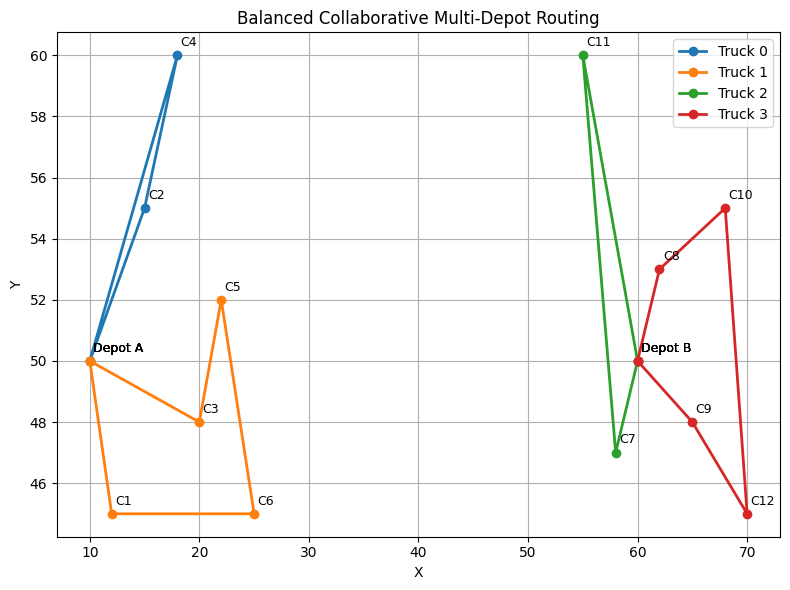

In [9]:
# Plotting
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown']
    for v in range(num_vehicles):
        index = routing.Start(v)
        xs, ys, labels = [], [], []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            name = node_names[node_index]
            x, y = locations[name]
            xs.append(x); ys.append(y); labels.append(name)
            index = solution.Value(routing.NextVar(index))
        # end node
        name = node_names[manager.IndexToNode(index)]
        x, y = locations[name]
        xs.append(x); ys.append(y); labels.append(name)
        plt.plot(xs, ys, marker='o', linewidth=2, label=f'Truck {v}', color=colors[v % len(colors)])
        for xi, yi, lab in zip(xs, ys, labels):
            plt.text(xi+0.3, yi+0.3, lab, fontsize=9)
    plt.title('Balanced Collaborative Multi-Depot Routing')
    plt.xlabel('X'); plt.ylabel('Y'); plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()
except Exception:
    print("Plotting failed. Ensure matplotlib is installed.")